In [1]:
from utils.flow_utils import flow_to_image, resize_flow
from utils.torch_utils import restore_model
from models.pwclite import PWCLite
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from easydict import EasyDict
from torchvision import transforms
from transforms import sep_transforms
from cv2 import cv2

In [2]:
path = '/nfs/bigcornea/add_disk0/shilinhu/SBU/SBUTrain4KRecoveredSmall/ShadowImages/lssd1.jpg'

In [3]:
img = Image.open(path).convert('RGB')

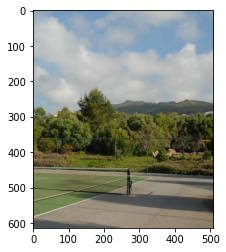

In [4]:
plt.imshow(img)

In [5]:
img = img.resize((500,500))

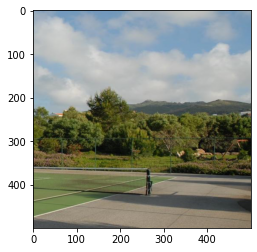

In [6]:
plt.imshow(img)

In [7]:
img1 = img.copy()
img2 = img.crop((50,50,500,500)).resize((500,500))

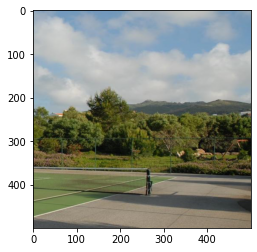

In [8]:
plt.imshow(img1)

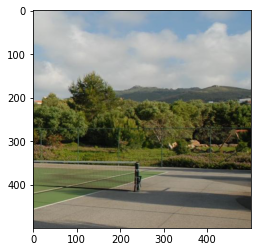

In [9]:
plt.imshow(img2)

In [10]:
img1 = np.asarray(img1).astype(np.float32)
img2 = np.asarray(img2).astype(np.float32)
imgs = [img1, img2]

In [11]:
class TestHelper():
    def __init__(self, cfg):
        self.cfg = EasyDict(cfg)
        self.device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
        self.model = self.init_model()
        self.input_transform = transforms.Compose([
            sep_transforms.Zoom(*self.cfg.test_shape),
            sep_transforms.ArrayToTensor(),
            transforms.Normalize(mean=[0, 0, 0], std=[255, 255, 255]),
        ])

    def init_model(self):
        model = PWCLite(self.cfg.model)
        # print('Number fo parameters: {}'.format(model.num_parameters()))
        model = model.to(self.device)
        model = restore_model(model, self.cfg.pretrained_model)
        model.eval()
        return model

    def run(self, imgs):
        imgs = [self.input_transform(img).unsqueeze(0) for img in imgs]
        img_pair = torch.cat(imgs, 1).to(self.device)
        return self.model(img_pair)

In [12]:
cfg = {
    'model': {
        'upsample': True,
        'n_frames': 2,
        'reduce_dense': True
    },
    'pretrained_model': 'checkpoints/Sintel/pwclite_ar.tar',
    'test_shape': [448, 1024],
}

ts = TestHelper(cfg)

In [13]:
flow_12 = ts.run(imgs)['flows_fw'][0]

In [14]:
flow_12 = resize_flow(flow_12, (500, 500))
np_flow_12 = flow_12[0].detach().cpu().numpy().transpose([1, 2, 0])
vis_flow = flow_to_image(np_flow_12)

In [15]:
h = np_flow_12.shape[0]
w = np_flow_12.shape[1]
np_flow_12[:,:,0] += np.arange(w)
np_flow_12[:,:,1] += np.arange(h)[:,np.newaxis]

In [16]:
new_img = cv2.remap(img2.astype(np.uint8), np_flow_12, None, cv2.INTER_LINEAR)

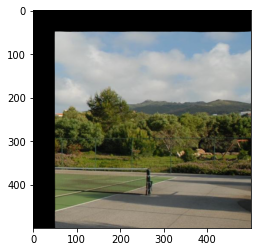

In [17]:
plt.imshow(new_img)